In [4]:
import os
converters = {8: lambda x: x == '"True"'}
data_dir= 'http://cdn.gea.esac.esa.int/Gaia/gdr3/Astrophysical_parameters/total_galactic_extinction_map/'


map_fname = os.path.join(data_dir,'TotalGalacticExtinctionMap_001.csv.gz')
dtype = [('solution_id', 'i8'),('healpix_id', 'i8'),('healpix_level', 'i1'),('a0', 'f4'),('a0_uncertainty', 'f4'),('a0_min', 'f4'),('a0_max', 'f4'),('num_tracers_used', 'i4'),('optimum_hpx_flag', '?'),('status', 'i2')]
d = np.genfromtxt(map_fname, comments='#', delimiter=',',encoding='utf-8', converters=converters,dtype=dtype)

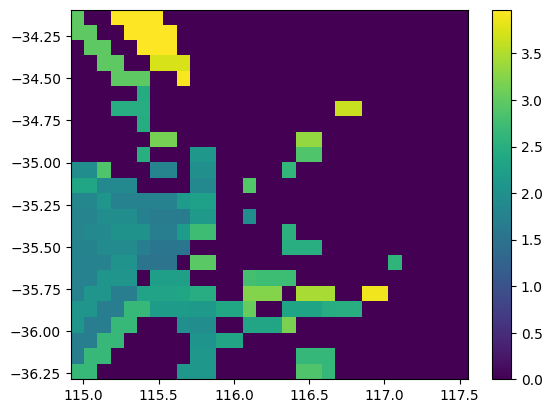

In [104]:
import os
import numpy as np
import healpy as hpp
from astropy.table import Table
import astropy.units as u
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from scipy.interpolate import griddata

cra=6+42/60+52.0/3600
cdec=27+22/60+56/3600

level=9

def eq2gal(ra, dec):
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    l,b = c.galactic.l.deg, c.galactic.b.deg
    return l, b
hp = HEALPix(nside=2**level, order='nested', frame='galactic')

l,b = eq2gal(cra, cdec)
coord = SkyCoord(l=l,b=b, unit=(u.degree, u.degree), frame='galactic')
search=hp.cone_search_skycoord(coord, radius=1 * u.deg)
 
common = d['healpix_id'][np.isin(d['healpix_id'],search)]
ext=d['a0'][np.isin(d['healpix_id'],search)]
ext[np.isnan(ext)] = 0

cd=hp.healpix_to_skycoord(common)  
l1=np.unique(cd.l.value)
b1=np.unique(cd.b.value)
X,Y= np.meshgrid(l1,b1)
beta= griddata(np.transpose(np.array([cd.l.value,cd.b.value])),np.array(ext),(X,Y),method='nearest')
plt.pcolormesh(X,Y,beta,cmap=plt.cm.viridis,shading='auto')
plt.colorbar()
plt.show()
plt.close()

In [114]:
def nside_to_pixel_area(nside):
    """
    Find the area of HEALPix pixels given the pixel dimensions of one of
    the 12 'top-level' HEALPix tiles.
    """
    nside = np.asanyarray(nside, dtype=np.int64)
    npix = 12 * nside * nside
    pixel_area = 4 * np.pi / npix * u.sr
    return pixel_area

In [115]:
def nside_to_pixel_resolution(nside):
    """
    Find the resolution of HEALPix pixels given the pixel dimensions of one of
    the 12 'top-level' HEALPix tiles.
    """
    nside = np.asanyarray(nside, dtype=np.int64)
    return (nside_to_pixel_area(nside) ** 0.5).to(u.arcmin)

In [118]:
#calc resolution
f=nside_to_pixel_resolution(2**level)
print(f)

6.870972823634812 arcmin
